### **Baseline Code Sources:** https://github.com/hosein-srj/Age-invariant-face-recognition-based-on-deep-features-analysis

### **Base Paper:** https://sci-hub.se/https://doi.org/10.1007/s11760-020-01635-1

# **Features with Fusion**

## **Importing Dataset**

**Downloading dataset from Google Drive**

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Unzipping Dataset**

---



In [ ]:
# Unzipping Downloaded Dataset
!unzip /content/drive/MyDrive/FGNET.zip
# Removing Unnecessary Folders
!rm -rf __MACOSX
!rm -rf images_new
# Creating new directory named 'images_new' to store pre-processed images
!mkdir images_new

Streaming output truncated to the last 5000 lines.
  inflating: FGNET/images/062A16.JPG  
  inflating: __MACOSX/FGNET/images/._062A16.JPG  
  inflating: FGNET/images/001A16.JPG  
  inflating: __MACOSX/FGNET/images/._001A16.JPG  
  inflating: FGNET/images/001A02.JPG  
  inflating: __MACOSX/FGNET/images/._001A02.JPG  
  inflating: FGNET/images/054A17.JPG  
  inflating: __MACOSX/FGNET/images/._054A17.JPG  
  inflating: FGNET/images/072A07.JPG  
  inflating: __MACOSX/FGNET/images/._072A07.JPG  
  inflating: FGNET/images/072A13.JPG  
  inflating: __MACOSX/FGNET/images/._072A13.JPG  
  inflating: FGNET/images/058A17.JPG  
  inflating: __MACOSX/FGNET/images/._058A17.JPG  
  inflating: FGNET/images/081A04.JPG  
  inflating: __MACOSX/FGNET/images/._081A04.JPG  
  inflating: FGNET/images/081A10.JPG  
  inflating: __MACOSX/FGNET/images/._081A10.JPG  
  inflating: FGNET/images/058A03.JPG  
  inflating: __MACOSX/FGNET/images/._058A03.JPG  
  inflating: FGNET/images/004A26.JPG  
  inflating: __MACOS

## **Data Pre-Processing**

**Data Pre-Processing involves tranformation of images such that images are well aligned frontally**

---



In [ ]:
# Importing Neccessary Modules
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import imutils
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.models import Model
from keras.models import Sequential
from tensorflow.keras import backend as K

# Getting face points
def get_pts(file_pts):
    pts = file_pts.readlines()
    pts = pts[3:len(pts) - 1]
    points = np.zeros((len(pts), 2))

    for i in range(len(pts)):
        pts[i] = pts[i].replace('\n', '')
        x = pts[i].split(' ')
        points[i][0] = float(x[0])
        points[i][1] = float(x[1])

    angle = math.atan2(points[31, 1] - points[36, 1], points[31, 0] - points[36, 0]) * 180 / math.pi
    if angle > 90:
        angle = angle - 180
    if angle < -90:
        angle = angle + 180
    return points, angle

# Image Pre-Processing
def preprocessing():
    image_path = "/content/FGNET/images"
    pts_path = "/content/FGNET/points"

    # Reading images and corresponding points from each specified folders
    for filename in os.listdir(image_path):
        # Reading images
        image = cv2.imread(os.path.join(image_path, filename))
        # Reading points
        name_pts = filename.split('.')[0].lower() + ".pts"
        # Coverting RGB image to Gray Scale color
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        file_pts = open(os.path.join(pts_path, name_pts))
        # Getting points (cropping) and corresponding angle (transformation - rotation) for each image
        points, angle = get_pts(file_pts)
        # Rotating image as per the angle
        rotated = imutils.rotate(image, angle)
        # Taking a reference point
        m_i = min(points[16][1], points[22][1])
        if filename != "033A30.JPG":
            # Cropping image as per the returned points
            croped = rotated[int(m_i - 10):int(points[7][1]), int(points[0][0] - 10):int(points[14][0] + 10)]
        else:
            # Cropping image as per the returned points
            croped = rotated[int(m_i - 10):int(points[7][1]), int(points[0][0]):int(points[14][0] + 5)]
        # Equalizing image
        rot_crop_his = cv2.equalizeHist(croped)
        try:
            # Saving pre-processed images in the new folder
            cv2.imwrite(os.path.join("/content/images_new", filename), rot_crop_his)
        except:
            print(filename)
# Invoking feature extraction function
if "__main__":
    preprocessing()

## **Feature Extraction**

**Feature Extraction using VGG-16 Model**

---



In [ ]:
# Retrieving images from pre-processed folder
def get_images_new():
    image_path = "images_new"
    labels = np.zeros((1, 1002))
    i = 0
    images = []
    print(labels.shape)
    # Looping over content in the pre-processed folder
    for filename in os.listdir(image_path):
        img = load_img(os.path.join(image_path, filename), target_size=(224, 224))
        img = img_to_array(img)
        images.append(img)
        # Labeling images
        labels[0][i] = int(filename.split('A')[0])
        i = i + 1
    # Returning images and their corresponding labels
    return np.array(images), labels

# Feature Extraction using VGG
def feature_extraction():
    # Definition of VGG
    model = tf.keras.applications.VGG16(
        include_top=True,
        weights="imagenet",
        input_tensor=None,
        input_shape=None,
        pooling=None,
        classes=1000,
        classifier_activation="softmax",
    )
    # 'images' variable contain images
    # 'labels' variable contain corresponding labels
    images, labels = get_images_new()
    # Creating a text file for extracted feature from VGG
    f = open('data.txt', 'w')
    l = len(model.layers)
    # Looping over images to extract features for each images
    for i in range(len(images)):
        image = images[i]
        img = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # Extracting features from Flatten layer
        keras_function = K.function([model.get_layer(index=0).input], model.get_layer(index=l - 4).output)
        Flatten = keras_function([img])
        # Extracting features from Fully Connected 7th layer
        keras_function = K.function([model.get_layer(index=0).input], model.get_layer(index=l - 3).output)
        FC7 = keras_function([img])
        # Extracting features from Fully Connected 6th layer
        keras_function = K.function([model.get_layer(index=0).input], model.get_layer(index=l - 2).output)
        FC6 = keras_function([img])
        # Saving extracted feature from 3 different layers and their corresponding labels
        f.write(str(labels[0][i]) + '\n')
        np.savetxt(f, Flatten, fmt="%s")
        np.savetxt(f, FC7, fmt="%s")
        np.savetxt(f, FC6, fmt="%s")
    # Closing the file
    f.close()

# Invoking feature extraction function
if "__main__":
    feature_extraction();

553467096/553467096 [==============================] - 24s 0us/step
(1, 1002)


**Feature Extraction using VGG-19 Model**

---



In [ ]:
from keras.applications import vgg19
from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg19 import decode_predictions
# Retrieving images from pre-processed folder
def get_images_new():
    image_path = "images_new"
    labels = np.zeros((1, 1002))
    i = 0
    images = []
    print(labels.shape)
    # Looping over content in the pre-processed folder
    for filename in os.listdir(image_path):
        img = load_img(os.path.join(image_path, filename), target_size=(224, 224))
        img = img_to_array(img)
        images.append(img)
        # Labeling images
        labels[0][i] = int(filename.split('A')[0])
        i = i + 1
    # Returning images and their corresponding labels
    return np.array(images), labels

# Feature Extraction using VGG
def feature_extraction():
    # Definition of VGG
    model = tf.keras.applications.VGG19(
        include_top=True,
        weights="imagenet",
        input_tensor=None,
        input_shape=None,
        pooling=None,
        classes=1000,
        classifier_activation="softmax",
    )
    # 'images' variable contain images
    # 'labels' variable contain corresponding labels
    images, labels = get_images_new()
    # Creating a text file for extracted feature from VGG
    f = open('data.txt', 'w')
    l = len(model.layers)
    # Looping over images to extract features for each images
    for i in range(len(images)):
        image = images[i]
        img = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # Extracting features from Flatten layer
        keras_function = K.function([model.get_layer(index=0).input], model.get_layer(index=l - 4).output)
        Flatten = keras_function([img])
        # Extracting features from Fully Connected 7th layer
        keras_function = K.function([model.get_layer(index=0).input], model.get_layer(index=l - 3).output)
        FC7 = keras_function([img])
        # Extracting features from Fully Connected 6th layer
        keras_function = K.function([model.get_layer(index=0).input], model.get_layer(index=l - 2).output)
        FC6 = keras_function([img])
        # Saving extracted feature from 3 different layers and their corresponding labels
        f.write(str(labels[0][i]) + '\n')
        np.savetxt(f, Flatten, fmt="%s")
        np.savetxt(f, FC7, fmt="%s")
        np.savetxt(f, FC6, fmt="%s")
    # Closing the file
    f.close()

# Invoking feature extraction function
if "__main__":
    feature_extraction();

574710816/574710816 [==============================] - 27s 0us/step
(1, 1002)


## **Feature Fusion**



**Source:** https://github.com/mhaghighat/dcaFuse

---


We will be using MATLAB code for Multi Discriminant Correlation Analysis (DCA) for feature fusion; because Python doesn't have built in libarary for DCA.

---



In [ ]:
# Installing octave for Matlab coding support
!apt install octave

In [ ]:
# Running 'main.m' file
# This file will return fused features into a file named 'features.txt'
!octave -W main.m # dcaFuse.m will be invoked from this file

      1   1002
   25088    1002
   4096   1002
   4096   1002


## **Features and label seperation**

In [ ]:
# Importing Necessary Modules
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

estimators = []

# Opening features.txt file
f = open('/content/features.txt', 'r')
# Initiazing an array of labels size
labels = np.zeros((1002))
# Creating an empty list for image features
images = []
# Looping over all the features from images
for i in range(1002):
    # Reading lines from features.txt file
    line = f.readline()
    # Replacing return with null character
    line = line.replace('\n','')
    # Stripping the line from right
    line = line.rstrip()
    # Splitting line with a white space
    line = line.split(' ')
    # Converting line into array
    line = np.array(line)
    # Changing the datatype to float
    line = line.astype(np.float)
    # Appending labels from files
    labels[i] = int(line[0])
    # Appending features from file
    images.append(line[1:82])
# Converting images features list to numpy array
images = np.array(images)

## **Hybrid Classifier on VGG-16**

In [ ]:
# ------------------------------------------------------------------------
#Defining 5 Decision Tree Classifiers
model16 = DecisionTreeClassifier()
estimators.append(('cart1', model16))
model17 = DecisionTreeClassifier()
estimators.append(('cart2', model17))
model18 = DecisionTreeClassifier()
estimators.append(('cart3', model18))
model19 = DecisionTreeClassifier()
estimators.append(('cart4', model19))
model20 = DecisionTreeClassifier()
estimators.append(('cart5', model20))

#Defining 5 Support Vector Classifiers
model21 = SVC()
estimators.append(('svm1', model21))
model22 = SVC(kernel = 'poly')
estimators.append(('svm2', model22))
model23 = SVC(kernel = 'rbf')
estimators.append(('svm3', model23))
model24 = SVC(kernel = 'rbf')
estimators.append(('svm4', model24))
model25 = SVC(kernel = 'linear')
estimators.append(('svm5', model25))

#Defining 5 Random Forest Classifiers
model26 = RandomForestClassifier(n_estimators=500)
estimators.append(('randomforest1', model26))
model27 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest2', model27))
model28 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest3', model28))
model29 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest4', model29))
model30 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest5', model30))

#Defining 5 Naive Bayes classifiers
model31 = GaussianNB()
estimators.append(('nbs1', model31))
model32 = GaussianNB()
estimators.append(('nbs2', model32))
model33 = GaussianNB()
estimators.append(('nbs3', model33))
model34 = GaussianNB()
estimators.append(('nbs4', model34))
model35 = GaussianNB()
estimators.append(('nbs5', model35))

# Defining the hybrid model
hybrid = VotingClassifier(estimators)

# ------------------------------------------------------------------------
# Scoring the rank-1 accuracy based on Cross-Fold Validation technique
scorers = {
            'f1_score': make_scorer(f1_score, average='macro'),
            'precision_score': make_scorer(precision_score, average='macro'),
            'recall_score': make_scorer(recall_score, average='macro'),
            'accuracy_score': make_scorer(accuracy_score)
          }
result = cross_validate(estimator=hybrid, X=images, y=labels, cv=5, scoring=scorers, error_score='raise')
print("------------------------------------------------------------------------")
print("Mean Rank-1 Recognition Rate: ", round(np.mean(result['test_accuracy_score']), 4))
print("------------------------------------------------------------------------")
print("Mean F1-Score: ", round(np.mean(result['test_f1_score']), 4))
print("Mean Precision: ", round(np.mean(result['test_precision_score']), 4))
print("Mean Recall: ", round(np.mean(result['test_recall_score']), 4))
print("------------------------------------------------------------------------")

------------------------------------------------------------------------
Mean Rank-1 Recognition Rate:  0.9161
------------------------------------------------------------------------
Mean F1-Score:  0.9061
Mean Precision:  0.9304
Mean Recall:  0.9102
------------------------------------------------------------------------


## **Single ML Algorithms on VGG-16**



---
Decision Tree


---





In [ ]:
decisionTree = DecisionTreeClassifier()
# ------------------------------------------------------------------------
# Scoring the rank-1 accuracy based on Cross-Fold Validation technique
scorers = {
            'f1_score': make_scorer(f1_score, average='macro'),
            'precision_score': make_scorer(precision_score, average='macro'),
            'recall_score': make_scorer(recall_score, average='macro'),
            'accuracy_score': make_scorer(accuracy_score)
          }
result = cross_validate(estimator=decisionTree, X=images, y=labels, cv=5, scoring=scorers, error_score='raise')
print("------------------------------------------------------------------------")
print("Mean Rank-1 Recognition Rate: ", round(np.mean(result['test_accuracy_score']), 4))
print("------------------------------------------------------------------------")
print("Mean F1-Score: ", round(np.mean(result['test_f1_score']), 4))
print("Mean Precision: ", round(np.mean(result['test_precision_score']), 4))
print("Mean Recall: ", round(np.mean(result['test_recall_score']), 4))
print("------------------------------------------------------------------------")

------------------------------------------------------------------------
Mean Rank-1 Recognition Rate:  0.2196
------------------------------------------------------------------------
Mean F1-Score:  0.1946
Mean Precision:  0.2054
Mean Recall:  0.214
------------------------------------------------------------------------




---
Naive Bayes


---





In [ ]:
naiveBayes = GaussianNB()
# ------------------------------------------------------------------------
# Scoring the rank-1 accuracy based on Cross-Fold Validation technique
scorers = {
            'f1_score': make_scorer(f1_score, average='macro'),
            'precision_score': make_scorer(precision_score, average='macro'),
            'recall_score': make_scorer(recall_score, average='macro'),
            'accuracy_score': make_scorer(accuracy_score)
          }
result = cross_validate(estimator=naiveBayes, X=images, y=labels, cv=5, scoring=scorers, error_score='raise')
print("------------------------------------------------------------------------")
print("Mean Rank-1 Recognition Rate: ", round(np.mean(result['test_accuracy_score']), 4))
print("------------------------------------------------------------------------")
print("Mean F1-Score: ", round(np.mean(result['test_f1_score']), 4))
print("Mean Precision: ", round(np.mean(result['test_precision_score']), 4))
print("Mean Recall: ", round(np.mean(result['test_recall_score']), 4))
print("------------------------------------------------------------------------")

------------------------------------------------------------------------
Mean Rank-1 Recognition Rate:  0.8613
------------------------------------------------------------------------
Mean F1-Score:  0.8481
Mean Precision:  0.8871
Mean Recall:  0.8522
------------------------------------------------------------------------




---
Random Forest


---





In [ ]:
randomForest = RandomForestClassifier()
# ------------------------------------------------------------------------
# Scoring the rank-1 accuracy based on Cross-Fold Validation technique
scorers = {
            'f1_score': make_scorer(f1_score, average='macro'),
            'precision_score': make_scorer(precision_score, average='macro'),
            'recall_score': make_scorer(recall_score, average='macro'),
            'accuracy_score': make_scorer(accuracy_score)
          }
result = cross_validate(estimator=randomForest, X=images, y=labels, cv=5, scoring=scorers, error_score='raise')
print("------------------------------------------------------------------------")
print("Mean Rank-1 Recognition Rate: ", round(np.mean(result['test_accuracy_score']), 4))
print("------------------------------------------------------------------------")
print("Mean F1-Score: ", round(np.mean(result['test_f1_score']), 4))
print("Mean Precision: ", round(np.mean(result['test_precision_score']), 4))
print("Mean Recall: ", round(np.mean(result['test_recall_score']), 4))
print("------------------------------------------------------------------------")

------------------------------------------------------------------------
Mean Rank-1 Recognition Rate:  0.7954
------------------------------------------------------------------------
Mean F1-Score:  0.7805
Mean Precision:  0.8265
Mean Recall:  0.7862
------------------------------------------------------------------------




---
SVM


---





In [ ]:
SVM = SVC(kernel = 'linear')
# ------------------------------------------------------------------------
# Scoring the rank-1 accuracy based on Cross-Fold Validation technique
scorers = {
            'f1_score': make_scorer(f1_score, average='macro'),
            'precision_score': make_scorer(precision_score, average='macro'),
            'recall_score': make_scorer(recall_score, average='macro'),
            'accuracy_score': make_scorer(accuracy_score)
          }
result = cross_validate(estimator=SVM, X=images, y=labels, cv=5, scoring=scorers, error_score='raise')
print("------------------------------------------------------------------------")
print("Mean Rank-1 Recognition Rate: ", round(np.mean(result['test_accuracy_score']), 4))
print("------------------------------------------------------------------------")
print("Mean F1-Score: ", round(np.mean(result['test_f1_score']), 4))
print("Mean Precision: ", round(np.mean(result['test_precision_score']), 4))
print("Mean Recall: ", round(np.mean(result['test_recall_score']), 4))
print("------------------------------------------------------------------------")

------------------------------------------------------------------------
Mean Rank-1 Recognition Rate:  0.8064
------------------------------------------------------------------------
Mean F1-Score:  0.7912
Mean Precision:  0.8555
Mean Recall:  0.7913
------------------------------------------------------------------------


## **Hybrid Classifier on VGG-19**

In [ ]:
# Importing Necessary Modules
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
import joblib

estimators = []

# Opening features.txt file
f = open('/content/features.txt', 'r')
# Initiazing an array of labels size
labels = np.zeros((1002))
# Creating an empty list for image features
images = []
# Looping over all the features from images
for i in range(1002):
    # Reading lines from features.txt file
    line = f.readline()
    # Replacing return with null character
    line = line.replace('\n','')
    # Stripping the line from right
    line = line.rstrip()
    # Splitting line with a white space
    line = line.split(' ')
    # Converting line into array
    line = np.array(line)
    # Changing the datatype to float
    line = line.astype(np.float)
    # Appending labels from files
    labels[i] = int(line[0])
    # Appending features from file
    images.append(line[1:82])
# Converting images features list to numpy array
images = np.array(images)

# ------------------------------------------------------------------------
#Defining 5 Decision Tree Classifiers
model16 = DecisionTreeClassifier()
estimators.append(('cart1', model16))
model17 = DecisionTreeClassifier()
estimators.append(('cart2', model17))
model18 = DecisionTreeClassifier()
estimators.append(('cart3', model18))
model19 = DecisionTreeClassifier()
estimators.append(('cart4', model19))
model20 = DecisionTreeClassifier()
estimators.append(('cart5', model20))

#Defining 5 Support Vector Classifiers
model21 = SVC()
estimators.append(('svm1', model21))
model22 = SVC(kernel = 'poly')
estimators.append(('svm2', model22))
model23 = SVC(kernel = 'rbf')
estimators.append(('svm3', model23))
model24 = SVC(kernel = 'rbf')
estimators.append(('svm4', model24))
model25 = SVC(kernel = 'linear')
estimators.append(('svm5', model25))

#Defining 5 Random Forest Classifiers
model26 = RandomForestClassifier(n_estimators=500)
estimators.append(('randomforest1', model26))
model27 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest2', model27))
model28 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest3', model28))
model29 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest4', model29))
model30 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest5', model30))

#Defining 5 Naive Bayes classifiers
model31 = GaussianNB()
estimators.append(('nbs1', model31))
model32 = GaussianNB()
estimators.append(('nbs2', model32))
model33 = GaussianNB()
estimators.append(('nbs3', model33))
model34 = GaussianNB()
estimators.append(('nbs4', model34))
model35 = GaussianNB()
estimators.append(('nbs5', model35))

# Defining the hybrid model
hybrid = VotingClassifier(estimators)

# ------------------------------------------------------------------------
# Scoring the rank-1 accuracy based on Cross-Fold Validation technique
scorers = {
            'f1_score': make_scorer(f1_score, average='macro'),
            'precision_score': make_scorer(precision_score, average='macro'),
            'recall_score': make_scorer(recall_score, average='macro'),
            'accuracy_score': make_scorer(accuracy_score)
          }
result = cross_validate(estimator=hybrid, X=images, y=labels, cv=5, scoring=scorers, error_score='raise')
print("------------------------------------------------------------------------")
print("Mean Rank-1 Recognition Rate: ", round(np.mean(result['test_accuracy_score']), 4))
print("------------------------------------------------------------------------")
print("Mean F1-Score: ", round(np.mean(result['test_f1_score']), 4))
print("Mean Precision: ", round(np.mean(result['test_precision_score']), 4))
print("Mean Recall: ", round(np.mean(result['test_recall_score']), 4))
print("------------------------------------------------------------------------")
joblib.dump(hybrid, 'hybrid.pkl')

------------------------------------------------------------------------
Mean Rank-1 Recognition Rate:  0.9262
------------------------------------------------------------------------
Mean F1-Score:  0.9167
Mean Precision:  0.9399
Mean Recall:  0.9201
------------------------------------------------------------------------
['hybrid.pkl']



## **Single ML Algorithms on VGG-19**



---
Decision Tree


---





In [ ]:
decisionTree = DecisionTreeClassifier()
# ------------------------------------------------------------------------
# Scoring the rank-1 accuracy based on Cross-Fold Validation technique
scorers = {
            'f1_score': make_scorer(f1_score, average='macro'),
            'precision_score': make_scorer(precision_score, average='macro'),
            'recall_score': make_scorer(recall_score, average='macro'),
            'accuracy_score': make_scorer(accuracy_score)
          }
result = cross_validate(estimator=decisionTree, X=images, y=labels, cv=5, scoring=scorers, error_score='raise')
print("------------------------------------------------------------------------")
print("Mean Rank-1 Recognition Rate: ", round(np.mean(result['test_accuracy_score']), 4))
print("------------------------------------------------------------------------")
print("Mean F1-Score: ", round(np.mean(result['test_f1_score']), 4))
print("Mean Precision: ", round(np.mean(result['test_precision_score']), 4))
print("Mean Recall: ", round(np.mean(result['test_recall_score']), 4))
print("------------------------------------------------------------------------")

------------------------------------------------------------------------
Mean Rank-1 Recognition Rate:  0.2215
------------------------------------------------------------------------
Mean F1-Score:  0.2014
Mean Precision:  0.2133
Mean Recall:  0.2222
------------------------------------------------------------------------




---
Naive Bayes


---





In [ ]:
naiveBayes = GaussianNB()
# ------------------------------------------------------------------------
# Scoring the rank-1 accuracy based on Cross-Fold Validation technique
scorers = {
            'f1_score': make_scorer(f1_score, average='macro'),
            'precision_score': make_scorer(precision_score, average='macro'),
            'recall_score': make_scorer(recall_score, average='macro'),
            'accuracy_score': make_scorer(accuracy_score)
          }
result = cross_validate(estimator=naiveBayes, X=images, y=labels, cv=5, scoring=scorers, error_score='raise')
print("------------------------------------------------------------------------")
print("Mean Rank-1 Recognition Rate: ", round(np.mean(result['test_accuracy_score']), 4))
print("------------------------------------------------------------------------")
print("Mean F1-Score: ", round(np.mean(result['test_f1_score']), 4))
print("Mean Precision: ", round(np.mean(result['test_precision_score']), 4))
print("Mean Recall: ", round(np.mean(result['test_recall_score']), 4))
print("------------------------------------------------------------------------")

------------------------------------------------------------------------
Mean Rank-1 Recognition Rate:  0.8383
------------------------------------------------------------------------
Mean F1-Score:  0.8231
Mean Precision:  0.8631
Mean Recall:  0.8329
------------------------------------------------------------------------




---
Random Forest


---





In [ ]:
randomForest = RandomForestClassifier()
# ------------------------------------------------------------------------
# Scoring the rank-1 accuracy based on Cross-Fold Validation technique
scorers = {
            'f1_score': make_scorer(f1_score, average='macro'),
            'precision_score': make_scorer(precision_score, average='macro'),
            'recall_score': make_scorer(recall_score, average='macro'),
            'accuracy_score': make_scorer(accuracy_score)
          }
result = cross_validate(estimator=randomForest, X=images, y=labels, cv=5, scoring=scorers, error_score='raise')
print("------------------------------------------------------------------------")
print("Mean Rank-1 Recognition Rate: ", round(np.mean(result['test_accuracy_score']), 4))
print("------------------------------------------------------------------------")
print("Mean F1-Score: ", round(np.mean(result['test_f1_score']), 4))
print("Mean Precision: ", round(np.mean(result['test_precision_score']), 4))
print("Mean Recall: ", round(np.mean(result['test_recall_score']), 4))
print("------------------------------------------------------------------------")

------------------------------------------------------------------------
Mean Rank-1 Recognition Rate:  0.7815
------------------------------------------------------------------------
Mean F1-Score:  0.7694
Mean Precision:  0.8143
Mean Recall:  0.7821
------------------------------------------------------------------------




---
SVM


---





In [ ]:
SVM = SVC(kernel = 'linear')
# ------------------------------------------------------------------------
# Scoring the rank-1 accuracy based on Cross-Fold Validation technique
scorers = {
            'f1_score': make_scorer(f1_score, average='macro'),
            'precision_score': make_scorer(precision_score, average='macro'),
            'recall_score': make_scorer(recall_score, average='macro'),
            'accuracy_score': make_scorer(accuracy_score)
          }
result = cross_validate(estimator=SVM, X=images, y=labels, cv=5, scoring=scorers, error_score='raise')
print("------------------------------------------------------------------------")
print("Mean Rank-1 Recognition Rate: ", round(np.mean(result['test_accuracy_score']), 4))
print("------------------------------------------------------------------------")
print("Mean F1-Score: ", round(np.mean(result['test_f1_score']), 4))
print("Mean Precision: ", round(np.mean(result['test_precision_score']), 4))
print("Mean Recall: ", round(np.mean(result['test_recall_score']), 4))
print("------------------------------------------------------------------------")

------------------------------------------------------------------------
Mean Rank-1 Recognition Rate:  0.8034
------------------------------------------------------------------------
Mean F1-Score:  0.7892
Mean Precision:  0.86
Mean Recall:  0.7868
------------------------------------------------------------------------


# **Features directly from Flatten, FC7, and FC6 - VGG-16**



---


**Extracting features seperately from Flatten, FC7, and FC6 layers**

---



In [ ]:
# Extracting features from flatten layer
!octave -W flatten.m

## **Flatten**

### **Features and Labels seperation for flatten layer**

In [ ]:
# Importing Necessary Modules
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

estimators = []

# Opening features.txt file
f = open('/content/flatten.txt', 'r')
# Initiazing an array of labels size
labels = np.zeros((1002))
# Creating an empty list for image features
images = []
# Looping over all the features from images
for i in range(1002):
    # Reading lines from features.txt file
    line = f.readline()
    # Replacing return with null character
    line = line.replace('\n','')
    # Stripping the line from right
    line = line.rstrip()
    # Splitting line with a white space
    line = line.split(' ')
    # Converting line into array
    line = np.array(line)
    # Changing the datatype to float
    line = line.astype(np.float)
    # Appending labels from files
    labels[i] = int(line[0])
    # Appending features from file
    images.append(line[1:25089])
# Converting images features list to numpy array
images = np.array(images)

### **Hybrid Classifier on Flatten layer**

In [ ]:
# ------------------------------------------------------------------------
#Defining 5 Decision Tree Classifiers
model16 = DecisionTreeClassifier()
estimators.append(('cart1', model16))
model17 = DecisionTreeClassifier()
estimators.append(('cart2', model17))
model18 = DecisionTreeClassifier()
estimators.append(('cart3', model18))
model19 = DecisionTreeClassifier()
estimators.append(('cart4', model19))
model20 = DecisionTreeClassifier()
estimators.append(('cart5', model20))

#Defining 5 Support Vector Classifiers
model21 = SVC()
estimators.append(('svm1', model21))
model22 = SVC(kernel = 'poly')
estimators.append(('svm2', model22))
model23 = SVC(kernel = 'rbf')
estimators.append(('svm3', model23))
model24 = SVC(kernel = 'rbf')
estimators.append(('svm4', model24))
model25 = SVC(kernel = 'linear')
estimators.append(('svm5', model25))

#Defining 5 Random Forest Classifiers
model26 = RandomForestClassifier(n_estimators=500)
estimators.append(('randomforest1', model26))
model27 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest2', model27))
model28 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest3', model28))
model29 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest4', model29))
model30 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest5', model30))

#Defining 5 Naive Bayes classifiers
model31 = GaussianNB()
estimators.append(('nbs1', model31))
model32 = GaussianNB()
estimators.append(('nbs2', model32))
model33 = GaussianNB()
estimators.append(('nbs3', model33))
model34 = GaussianNB()
estimators.append(('nbs4', model34))
model35 = GaussianNB()
estimators.append(('nbs5', model35))

# Defining the hybrid model
hybrid = VotingClassifier(estimators)

# ------------------------------------------------------------------------
# Scoring the rank-1 accuracy based on Cross-Fold Validation technique
scorers = {
            'f1_score': make_scorer(f1_score, average='macro'),
            'precision_score': make_scorer(precision_score, average='macro'),
            'recall_score': make_scorer(recall_score, average='macro'),
            'accuracy_score': make_scorer(accuracy_score)
          }
result = cross_validate(estimator=hybrid, X=images, y=labels, cv=5, scoring=scorers, error_score='raise')
print("------------------------------------------------------------------------")
print("Mean Rank-1 Recognition Rate: ", round(np.mean(result['test_accuracy_score']), 4))
print("------------------------------------------------------------------------")
print("Mean F1-Score: ", round(np.mean(result['test_f1_score']), 4))
print("Mean Precision: ", round(np.mean(result['test_precision_score']), 4))
print("Mean Recall: ", round(np.mean(result['test_recall_score']), 4))
print("------------------------------------------------------------------------")

------------------------------------------------------------------------
Mean Rank-1 Recognition Rate:  0.7193
------------------------------------------------------------------------
Mean F1-Score:  0.7106
Mean Precision:  0.7113
Mean Recall:  0.7181
------------------------------------------------------------------------


## **FC7**

### **Features and Labels seperation for fc7 layer**

In [ ]:
estimators = []

# Opening features.txt file
f = open('/content/FC7.txt', 'r')
# Initiazing an array of labels size
labels = np.zeros((1002))
# Creating an empty list for image features
images = []
# Looping over all the features from images
for i in range(1002):
    # Reading lines from features.txt file
    line = f.readline()
    # Replacing return with null character
    line = line.replace('\n','')
    # Stripping the line from right
    line = line.rstrip()
    # Splitting line with a white space
    line = line.split(' ')
    # Converting line into array
    line = np.array(line)
    # Changing the datatype to float
    line = line.astype(np.float)
    # Appending labels from files
    labels[i] = int(line[0])
    # Appending features from file
    images.append(line[1:4097])
# Converting images features list to numpy array
images = np.array(images)

### **Hybrid Classifier on fc7 layer**

In [ ]:
# ------------------------------------------------------------------------
#Defining 5 Decision Tree Classifiers
model16 = DecisionTreeClassifier()
estimators.append(('cart1', model16))
model17 = DecisionTreeClassifier()
estimators.append(('cart2', model17))
model18 = DecisionTreeClassifier()
estimators.append(('cart3', model18))
model19 = DecisionTreeClassifier()
estimators.append(('cart4', model19))
model20 = DecisionTreeClassifier()
estimators.append(('cart5', model20))

#Defining 5 Support Vector Classifiers
model21 = SVC()
estimators.append(('svm1', model21))
model22 = SVC(kernel = 'poly')
estimators.append(('svm2', model22))
model23 = SVC(kernel = 'rbf')
estimators.append(('svm3', model23))
model24 = SVC(kernel = 'rbf')
estimators.append(('svm4', model24))
model25 = SVC(kernel = 'linear')
estimators.append(('svm5', model25))

#Defining 5 Random Forest Classifiers
model26 = RandomForestClassifier(n_estimators=500)
estimators.append(('randomforest1', model26))
model27 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest2', model27))
model28 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest3', model28))
model29 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest4', model29))
model30 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest5', model30))

#Defining 5 Naive Bayes classifiers
model31 = GaussianNB()
estimators.append(('nbs1', model31))
model32 = GaussianNB()
estimators.append(('nbs2', model32))
model33 = GaussianNB()
estimators.append(('nbs3', model33))
model34 = GaussianNB()
estimators.append(('nbs4', model34))
model35 = GaussianNB()
estimators.append(('nbs5', model35))

# Defining the hybrid model
hybrid = VotingClassifier(estimators)

# ------------------------------------------------------------------------
# Scoring the rank-1 accuracy based on Cross-Fold Validation technique
scorers = {
            'f1_score': make_scorer(f1_score, average='macro'),
            'precision_score': make_scorer(precision_score, average='macro'),
            'recall_score': make_scorer(recall_score, average='macro'),
            'accuracy_score': make_scorer(accuracy_score)
          }
result = cross_validate(estimator=hybrid, X=images, y=labels, cv=5, scoring=scorers, error_score='raise')
print("------------------------------------------------------------------------")
print("Mean Rank-1 Recognition Rate: ", round(np.mean(result['test_accuracy_score']), 4))
print("------------------------------------------------------------------------")
print("Mean F1-Score: ", round(np.mean(result['test_f1_score']), 4))
print("Mean Precision: ", round(np.mean(result['test_precision_score']), 4))
print("Mean Recall: ", round(np.mean(result['test_recall_score']), 4))
print("------------------------------------------------------------------------")

------------------------------------------------------------------------
Mean Rank-1 Recognition Rate:  0.7875
------------------------------------------------------------------------
Mean F1-Score:  0.7819
Mean Precision:  0.7796
Mean Recall:  0.7815
------------------------------------------------------------------------


## **FC6**

### **Features and Labels seperation for fc6 layer**

In [ ]:
estimators = []

# Opening features.txt file
f = open('/content/FC6.txt', 'r')
# Initiazing an array of labels size
labels = np.zeros((1002))
# Creating an empty list for image features
images = []
# Looping over all the features from images
for i in range(1002):
    # Reading lines from features.txt file
    line = f.readline()
    # Replacing return with null character
    line = line.replace('\n','')
    # Stripping the line from right
    line = line.rstrip()
    # Splitting line with a white space
    line = line.split(' ')
    # Converting line into array
    line = np.array(line)
    # Changing the datatype to float
    line = line.astype(np.float)
    # Appending labels from files
    labels[i] = int(line[0])
    # Appending features from file
    images.append(line[1:4096])
# Converting images features list to numpy array
images = np.array(images)

### **Hybrid Classifier on fc6 layer**

In [ ]:
# ------------------------------------------------------------------------
#Defining 5 Decision Tree Classifiers
model16 = DecisionTreeClassifier()
estimators.append(('cart1', model16))
model17 = DecisionTreeClassifier()
estimators.append(('cart2', model17))
model18 = DecisionTreeClassifier()
estimators.append(('cart3', model18))
model19 = DecisionTreeClassifier()
estimators.append(('cart4', model19))
model20 = DecisionTreeClassifier()
estimators.append(('cart5', model20))

#Defining 5 Support Vector Classifiers
model21 = SVC()
estimators.append(('svm1', model21))
model22 = SVC(kernel = 'poly')
estimators.append(('svm2', model22))
model23 = SVC(kernel = 'rbf')
estimators.append(('svm3', model23))
model24 = SVC(kernel = 'rbf')
estimators.append(('svm4', model24))
model25 = SVC(kernel = 'linear')
estimators.append(('svm5', model25))

#Defining 5 Random Forest Classifiers
model26 = RandomForestClassifier(n_estimators=500)
estimators.append(('randomforest1', model26))
model27 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest2', model27))
model28 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest3', model28))
model29 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest4', model29))
model30 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest5', model30))

#Defining 5 Naive Bayes classifiers
model31 = GaussianNB()
estimators.append(('nbs1', model31))
model32 = GaussianNB()
estimators.append(('nbs2', model32))
model33 = GaussianNB()
estimators.append(('nbs3', model33))
model34 = GaussianNB()
estimators.append(('nbs4', model34))
model35 = GaussianNB()
estimators.append(('nbs5', model35))

# Defining the hybrid model
hybrid = VotingClassifier(estimators)

# ------------------------------------------------------------------------
# Scoring the rank-1 accuracy based on Cross-Fold Validation technique
scorers = {
            'f1_score': make_scorer(f1_score, average='macro'),
            'precision_score': make_scorer(precision_score, average='macro'),
            'recall_score': make_scorer(recall_score, average='macro'),
            'accuracy_score': make_scorer(accuracy_score)
          }
result = cross_validate(estimator=hybrid, X=images, y=labels, cv=5, scoring=scorers, error_score='raise')
print("------------------------------------------------------------------------")
print("Mean Rank-1 Recognition Rate: ", round(np.mean(result['test_accuracy_score']), 4))
print("------------------------------------------------------------------------")
print("Mean F1-Score: ", round(np.mean(result['test_f1_score']), 4))
print("Mean Precision: ", round(np.mean(result['test_precision_score']), 4))
print("Mean Recall: ", round(np.mean(result['test_recall_score']), 4))
print("------------------------------------------------------------------------")

------------------------------------------------------------------------
Mean Rank-1 Recognition Rate:  0.8063
------------------------------------------------------------------------
Mean F1-Score:  0.8025
Mean Precision:  0.8008
Mean Recall:  0.8017
------------------------------------------------------------------------


# **Features directly from Flatten, FC7, and FC6 - VGG-19**



---


**Extracting features seperately from Flatten, FC7, and FC6 layers**

---



In [ ]:
!octave -W flatten-fc7-fc6.m

## **Flatten**

### **Features and Labels seperation for flatten layer**

In [ ]:
# Importing Necessary Modules
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

estimators = []

# Opening features.txt file
f = open('/content/flatten.txt', 'r')
# Initiazing an array of labels size
labels = np.zeros((1002))
# Creating an empty list for image features
images = []
# Looping over all the features from images
for i in range(1002):
    # Reading lines from features.txt file
    line = f.readline()
    # Replacing return with null character
    line = line.replace('\n','')
    # Stripping the line from right
    line = line.rstrip()
    # Splitting line with a white space
    line = line.split(' ')
    # Converting line into array
    line = np.array(line)
    # Changing the datatype to float
    line = line.astype(np.float)
    # Appending labels from files
    labels[i] = int(line[0])
    # Appending features from file
    images.append(line[1:25089])
# Converting images features list to numpy array
images = np.array(images)

### **Hybrid Classifier on Flatten layer**

In [ ]:
# ------------------------------------------------------------------------
#Defining 5 Decision Tree Classifiers
model16 = DecisionTreeClassifier()
estimators.append(('cart1', model16))
model17 = DecisionTreeClassifier()
estimators.append(('cart2', model17))
model18 = DecisionTreeClassifier()
estimators.append(('cart3', model18))
model19 = DecisionTreeClassifier()
estimators.append(('cart4', model19))
model20 = DecisionTreeClassifier()
estimators.append(('cart5', model20))

#Defining 5 Support Vector Classifiers
model21 = SVC()
estimators.append(('svm1', model21))
model22 = SVC(kernel = 'poly')
estimators.append(('svm2', model22))
model23 = SVC(kernel = 'rbf')
estimators.append(('svm3', model23))
model24 = SVC(kernel = 'rbf')
estimators.append(('svm4', model24))
model25 = SVC(kernel = 'linear')
estimators.append(('svm5', model25))

#Defining 5 Random Forest Classifiers
model26 = RandomForestClassifier(n_estimators=500)
estimators.append(('randomforest1', model26))
model27 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest2', model27))
model28 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest3', model28))
model29 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest4', model29))
model30 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest5', model30))

#Defining 5 Naive Bayes classifiers
model31 = GaussianNB()
estimators.append(('nbs1', model31))
model32 = GaussianNB()
estimators.append(('nbs2', model32))
model33 = GaussianNB()
estimators.append(('nbs3', model33))
model34 = GaussianNB()
estimators.append(('nbs4', model34))
model35 = GaussianNB()
estimators.append(('nbs5', model35))

# Defining the hybrid model
hybrid = VotingClassifier(estimators)

# ------------------------------------------------------------------------
# Scoring the rank-1 accuracy based on Cross-Fold Validation technique
scorers = {
            'f1_score': make_scorer(f1_score, average='macro'),
            'precision_score': make_scorer(precision_score, average='macro'),
            'recall_score': make_scorer(recall_score, average='macro'),
            'accuracy_score': make_scorer(accuracy_score)
          }
result = cross_validate(estimator=hybrid, X=images, y=labels, cv=5, scoring=scorers, error_score='raise')
print("------------------------------------------------------------------------")
print("Mean Rank-1 Recognition Rate: ", round(np.mean(result['test_accuracy_score']), 4))
print("------------------------------------------------------------------------")
print("Mean F1-Score: ", round(np.mean(result['test_f1_score']), 4))
print("Mean Precision: ", round(np.mean(result['test_precision_score']), 4))
print("Mean Recall: ", round(np.mean(result['test_recall_score']), 4))
print("------------------------------------------------------------------------")

------------------------------------------------------------------------
Mean Rank-1 Recognition Rate:  0.7282
------------------------------------------------------------------------
Mean F1-Score:  0.7236
Mean Precision:  0.7266
Mean Recall:  0.7269
------------------------------------------------------------------------


## **FC7**

### **Features and Labels seperation for fc7 layer**

In [ ]:
estimators = []

# Opening features.txt file
f = open('/content/FC7.txt', 'r')
# Initiazing an array of labels size
labels = np.zeros((1002))
# Creating an empty list for image features
images = []
# Looping over all the features from images
for i in range(1002):
    # Reading lines from features.txt file
    line = f.readline()
    # Replacing return with null character
    line = line.replace('\n','')
    # Stripping the line from right
    line = line.rstrip()
    # Splitting line with a white space
    line = line.split(' ')
    # Converting line into array
    line = np.array(line)
    # Changing the datatype to float
    line = line.astype(np.float)
    # Appending labels from files
    labels[i] = int(line[0])
    # Appending features from file
    images.append(line[1:4097])
# Converting images features list to numpy array
images = np.array(images)

### **Hybrid Classifier on fc7 layer**

In [ ]:
# ------------------------------------------------------------------------
#Defining 5 Decision Tree Classifiers
model16 = DecisionTreeClassifier()
estimators.append(('cart1', model16))
model17 = DecisionTreeClassifier()
estimators.append(('cart2', model17))
model18 = DecisionTreeClassifier()
estimators.append(('cart3', model18))
model19 = DecisionTreeClassifier()
estimators.append(('cart4', model19))
model20 = DecisionTreeClassifier()
estimators.append(('cart5', model20))

#Defining 5 Support Vector Classifiers
model21 = SVC()
estimators.append(('svm1', model21))
model22 = SVC(kernel = 'poly')
estimators.append(('svm2', model22))
model23 = SVC(kernel = 'rbf')
estimators.append(('svm3', model23))
model24 = SVC(kernel = 'rbf')
estimators.append(('svm4', model24))
model25 = SVC(kernel = 'linear')
estimators.append(('svm5', model25))

#Defining 5 Random Forest Classifiers
model26 = RandomForestClassifier(n_estimators=500)
estimators.append(('randomforest1', model26))
model27 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest2', model27))
model28 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest3', model28))
model29 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest4', model29))
model30 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest5', model30))

#Defining 5 Naive Bayes classifiers
model31 = GaussianNB()
estimators.append(('nbs1', model31))
model32 = GaussianNB()
estimators.append(('nbs2', model32))
model33 = GaussianNB()
estimators.append(('nbs3', model33))
model34 = GaussianNB()
estimators.append(('nbs4', model34))
model35 = GaussianNB()
estimators.append(('nbs5', model35))

# Defining the hybrid model
hybrid = VotingClassifier(estimators)

# ------------------------------------------------------------------------
# Scoring the rank-1 accuracy based on Cross-Fold Validation technique
scorers = {
            'f1_score': make_scorer(f1_score, average='macro'),
            'precision_score': make_scorer(precision_score, average='macro'),
            'recall_score': make_scorer(recall_score, average='macro'),
            'accuracy_score': make_scorer(accuracy_score)
          }
result = cross_validate(estimator=hybrid, X=images, y=labels, cv=5, scoring=scorers, error_score='raise')
print("------------------------------------------------------------------------")
print("Mean Rank-1 Recognition Rate: ", round(np.mean(result['test_accuracy_score']), 4))
print("------------------------------------------------------------------------")
print("Mean F1-Score: ", round(np.mean(result['test_f1_score']), 4))
print("Mean Precision: ", round(np.mean(result['test_precision_score']), 4))
print("Mean Recall: ", round(np.mean(result['test_recall_score']), 4))
print("------------------------------------------------------------------------")

------------------------------------------------------------------------
Mean Rank-1 Recognition Rate:  0.8133
------------------------------------------------------------------------
Mean F1-Score:  0.8114
Mean Precision:  0.8109
Mean Recall:  0.8131
------------------------------------------------------------------------


## **FC6**

### **Features and Labels seperation for fc6 layer**

In [ ]:
estimators = []

# Opening features.txt file
f = open('/content/FC6.txt', 'r')
# Initiazing an array of labels size
labels = np.zeros((1002))
# Creating an empty list for image features
images = []
# Looping over all the features from images
for i in range(1002):
    # Reading lines from features.txt file
    line = f.readline()
    # Replacing return with null character
    line = line.replace('\n','')
    # Stripping the line from right
    line = line.rstrip()
    # Splitting line with a white space
    line = line.split(' ')
    # Converting line into array
    line = np.array(line)
    # Changing the datatype to float
    line = line.astype(np.float)
    # Appending labels from files
    labels[i] = int(line[0])
    # Appending features from file
    images.append(line[1:4096])
# Converting images features list to numpy array
images = np.array(images)

### **Hybrid Classifier on fc6 layer**

In [ ]:
# ------------------------------------------------------------------------
#Defining 5 Decision Tree Classifiers
model16 = DecisionTreeClassifier()
estimators.append(('cart1', model16))
model17 = DecisionTreeClassifier()
estimators.append(('cart2', model17))
model18 = DecisionTreeClassifier()
estimators.append(('cart3', model18))
model19 = DecisionTreeClassifier()
estimators.append(('cart4', model19))
model20 = DecisionTreeClassifier()
estimators.append(('cart5', model20))

#Defining 5 Support Vector Classifiers
model21 = SVC()
estimators.append(('svm1', model21))
model22 = SVC(kernel = 'poly')
estimators.append(('svm2', model22))
model23 = SVC(kernel = 'rbf')
estimators.append(('svm3', model23))
model24 = SVC(kernel = 'rbf')
estimators.append(('svm4', model24))
model25 = SVC(kernel = 'linear')
estimators.append(('svm5', model25))

#Defining 5 Random Forest Classifiers
model26 = RandomForestClassifier(n_estimators=500)
estimators.append(('randomforest1', model26))
model27 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest2', model27))
model28 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest3', model28))
model29 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest4', model29))
model30 = RandomForestClassifier(n_estimators=800)
estimators.append(('randomforest5', model30))

#Defining 5 Naive Bayes classifiers
model31 = GaussianNB()
estimators.append(('nbs1', model31))
model32 = GaussianNB()
estimators.append(('nbs2', model32))
model33 = GaussianNB()
estimators.append(('nbs3', model33))
model34 = GaussianNB()
estimators.append(('nbs4', model34))
model35 = GaussianNB()
estimators.append(('nbs5', model35))

# Defining the hybrid model
hybrid = VotingClassifier(estimators)

# ------------------------------------------------------------------------
# Scoring the rank-1 accuracy based on Cross-Fold Validation technique
scorers = {
            'f1_score': make_scorer(f1_score, average='macro'),
            'precision_score': make_scorer(precision_score, average='macro'),
            'recall_score': make_scorer(recall_score, average='macro'),
            'accuracy_score': make_scorer(accuracy_score)
          }
result = cross_validate(estimator=hybrid, X=images, y=labels, cv=5, scoring=scorers, error_score='raise')
print("------------------------------------------------------------------------")
print("Mean Rank-1 Recognition Rate: ", round(np.mean(result['test_accuracy_score']), 4))
print("------------------------------------------------------------------------")
print("Mean F1-Score: ", round(np.mean(result['test_f1_score']), 4))
print("Mean Precision: ", round(np.mean(result['test_precision_score']), 4))
print("Mean Recall: ", round(np.mean(result['test_recall_score']), 4))
print("------------------------------------------------------------------------")

------------------------------------------------------------------------
Mean Rank-1 Recognition Rate:  0.8172
------------------------------------------------------------------------
Mean F1-Score:  0.8138
Mean Precision:  0.8159
Mean Recall:  0.8158
------------------------------------------------------------------------


# **Model Test**

In [ ]:
# Making directory for uploading image
!mkdir upload_image

In [ ]:
import joblib
import re
from PIL import Image
# Load the model from the file
hybridClassifier = joblib.load('hybrid.pkl')

In [ ]:
# Run this before testing new images after testing one
!rm -rf upload_image/.ipynb_checkpoints

Matched with person number 13


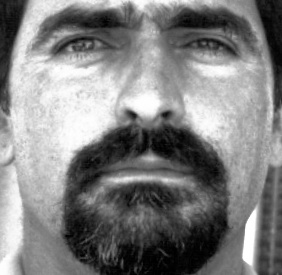

In [ ]:
image_path = "upload_image"
label = np.zeros((1, 1))
i = 0

for filename in os.listdir(image_path):
    img = load_img(os.path.join(image_path, filename), target_size=(224, 224))
    image = img_to_array(img)
    label = float(filename.split('A')[0])
    i = i + 1

index = np.where(labels == label)
singleFeature = images[index[0][0]].reshape(-1, 1)
singleFeature = np.transpose(singleFeature)

filenames = []
image_path = "images_new"
for filename in os.listdir(image_path):
  filenames.append(filename)

y_predict = hybridClassifier.predict(singleFeature)
predPerson = int(y_predict)
predPerson

if(len(str(predPerson)) == 1):
  string = "00" + str(predPerson) + "A"
  for filename in filenames:
    if re.search(string, filename):
      x = filename
else:
  string = "0" + str(predPerson) + "A"
  for filename in filenames:
    if re.search(string, filename):
      x = filename

print("Matched with person number " + str(predPerson))
im = Image.open(r"/content/images_new/" + x)
im